# EDA

## Imports

In [ ]:
import kagglehub
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Downloading Data

In [ ]:
# Download latest version
path = Path(kagglehub.dataset_download("sumanthvrao/daily-climate-time-series-data"))

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'daily-climate-time-series-data' dataset.
Path to dataset files: /kaggle/input/daily-climate-time-series-data


In [ ]:
train_ds = pd.read_csv(path / 'DailyDelhiClimateTrain.csv')
test_ds = pd.read_csv(path / 'DailyDelhiClimateTest.csv')


## Utils


In [ ]:
from scipy.stats import spearmanr

def plot_bivariate_scatter(data, lag=0, size=(10,8)):
    """
    Plots a matrix of bivariate scatter plots for the columns of a DataFrame.
    The main diagonal shows histograms, the lower triangle shows scatter plots
    with an optional lag, and the upper triangle shows Spearman correlation coefficients.
    Variable names are placed on the extreme left and bottom axes, and axis ticks are shown.

    Args:
        data (pd.DataFrame): The DataFrame containing the variables to plot.
        lag (int): The lag to apply to the x-axis variable in the lower triangle scatter plots.
    """

    vars_to_plot = data.columns
    num_vars = len(vars_to_plot)

    fig, axes = plt.subplots(nrows=num_vars, ncols=num_vars, figsize=size)
    fig.suptitle(f"Bivariate Scatter Matrix (Lag = {lag})", fontsize=16, fontweight='bold', y=1.02)

    for i in range(num_vars):
        for j in range(num_vars):
            var1 = vars_to_plot[i]
            var2 = vars_to_plot[j]

            # ==== Diagonal: histograma ====
            if i == j:
                axes[i, j].hist(data[var1].dropna(), bins=20)
                axes[i, j].set_title('')

            # ==== Triângulo inferior: scatter (sem regressão) ====
            elif i > j:
                lagged_var1 = data[var1].shift(lag).dropna()

                if lag > 0:
                    aligned_var2 = data[var2].iloc[lag:].dropna()
                else:
                    aligned_var2 = data[var2].dropna()

                common_index = lagged_var1.index.intersection(aligned_var2.index)

                lagged_var1_aligned = lagged_var1.loc[common_index]
                aligned_var2_aligned = aligned_var2.loc[common_index]

                if not lagged_var1_aligned.empty and not aligned_var2_aligned.empty:
                    axes[i, j].scatter(
                        lagged_var1_aligned,
                        aligned_var2_aligned,
                        alpha=0.5
                    )

                    # 🔹 Texto indicando qual variável foi lagada
                    axes[i, j].text(
                        0.05, 0.9,
                        f"{var1}\n(Lag = {lag})",
                        transform=axes[i, j].transAxes,
                        fontsize=8.5,
                        color='darkgreen',
                        ha='left',
                        va='top',
                        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.6)
                    )

            # ==== Triângulo superior: Spearman ====
            elif i < j:

                if lag > 0:
                    corr_data = pd.DataFrame({
                        var1: data[var1].shift(lag),
                        var2: data[var2].iloc[lag:]
                    }).dropna()
                else:
                    corr_data = data[[var1, var2]].dropna()

                if len(corr_data) > 1:
                    corr_coef, _ = spearmanr(corr_data[var1], corr_data[var2])

                    axes[i, j].text(
                        0.5, 0.5,
                        f"ρ = {corr_coef:.2f}",
                        ha='center',
                        va='center',
                        fontsize=12,
                        color='blue',
                        transform=axes[i, j].transAxes
                    )
                else:
                    axes[i, j].text(
                        0.5, 0.5,
                        'Not enough data',
                        ha='center',
                        va='center',
                        fontsize=10,
                        color='red',
                        transform=axes[i, j].transAxes
                    )

                axes[i, j].axis('off')

            # ==== Rótulos nas bordas ====
            if j == 0:
                axes[i, j].set_ylabel(var1, rotation=90, size='large')
            if i == num_vars - 1:
                axes[i, j].set_xlabel(var2, size='large')

    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

def plot_pairwise_crosscorrelations(data, max_lag=30):
    """
    Calcula e plota a cross-correlation function (CCF) entre todas as combinações 2 a 2 de variáveis numéricas.

    Args:
        data (pd.DataFrame): dataset contendo as variáveis numéricas.
        max_lag (int): número máximo de defasagens a considerar.
    """
    # Seleciona apenas colunas numéricas
    num_cols = data.select_dtypes(include=np.number).columns
    num_pairs = len(num_cols)

    # Loop 2 a 2
    for i in range(num_pairs):
        for j in range(i+1, num_pairs):
            var1 = num_cols[i]
            var2 = num_cols[j]

            # Remove NaNs
            x = data[var1].dropna()
            y = data[var2].dropna()
            min_len = min(len(x), len(y))
            x, y = x.iloc[:min_len], y.iloc[:min_len]

            # Calcula CCF usando statsmodels
            corr_vals = ccf(x - np.mean(x), y - np.mean(y))[:max_lag+1]
            lags = np.arange(0, max_lag+1)

            # Plot
            plt.figure(figsize=(8, 4))
            plt.bar(lags, corr_vals, width=0.4, color='royalblue')
            plt.axhline(0, color='black', linewidth=1)
            plt.title(f"Cross-Correlation Function: {var1} vs {var2}", fontsize=12)
            plt.xlabel("Lag (k)")
            plt.ylabel("CCF")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()


In [ ]:
from scipy.stats import median_abs_deviation

# calcula o robust z-score
def robust_zscore(series):
    median = np.median(series)
    mad = median_abs_deviation(series, scale='normal')  # já inclui o fator 0.6745
    return (series - median) / mad


## Exploratory Data Analysis

In [ ]:
train_ds.duplicated().sum()


np.int64(0)

Não há dados duplicados

In [ ]:
train_ds.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
print('--- Train Dataset Dates ---')
print(f"Start Date: {train_ds['date'].min()}")
print(f"End Date: {train_ds['date'].max()}")
print(f"Number of days: {train_ds['date'].nunique()}")

print('\n--- Test Dataset Dates ---')
print(f"Start Date: {test_ds['date'].min()}")
print(f"End Date: {test_ds['date'].max()}")
print(f"Number of days: {test_ds['date'].nunique()}")

--- Train Dataset Dates ---
Start Date: 2013-01-01
End Date: 2017-01-01
Number of days: 1462

--- Test Dataset Dates ---
Start Date: 2017-01-01
End Date: 2017-04-24
Number of days: 114


In [ ]:
train_ds.shape

(1462, 5)

In [ ]:
train_ds['date'] = pd.to_datetime(train_ds['date'])
test_ds['date'] = pd.to_datetime(test_ds['date'])

In [ ]:
train_ds.isnull().sum()

,0
date,0
meantemp,0
humidity,0
wind_speed,0
meanpressure,0


In [ ]:
train_ds.drop('date', axis=1).describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


meanpressure possui valores negativos ou grandes demais (7679), possíveis erros;


In [ ]:
# Check the frequency of the data by looking at the difference between consecutive dates
time_diff = train_ds['date'].diff().mode()
print(f"Typical time difference between observations (frequency): {time_diff[0]}")

# Get the start and end dates
start_date = train_ds['date'].min()
end_date = train_ds['date'].max()

print(f"Start date of observations: {start_date}")
print(f"End date of observations: {end_date}")

Typical time difference between observations (frequency): 1 days 00:00:00
Start date of observations: 2013-01-01 00:00:00
End date of observations: 2017-01-01 00:00:00


In [ ]:
train_ds['date'].diff().value_counts()

,count
date,
1 days,1461


sem buracos temporais

a média das diferenças é zero, logo há indícios de que não há tendência (crescimento ou decrescimento) (os valores se cancelam)

meanpressure tem caldas altamente pesadas (indício de outliers)

robust Z-score para encontrar os outliers

* Não supõe normalidade
* lida bem com distribuições aproximadamente simétricas
* lida bem com distribuições com caudas longas/pesadas
* Usa estatísticas robustas (median e median_abs_deviation)


In [ ]:
# meanpressure
z1 = robust_zscore(train_ds['meanpressure'])
outliers_meanpressure = train_ds[np.abs(z1) > 3.5]
outliers_meanpressure['meanpressure']

,meanpressure
1182,7679.333333
1255,938.066667
1300,946.312500
1309,310.437500
1321,633.900000
1323,-3.041667
1362,1352.615385
1416,1350.296296
1427,12.045455


A forte assimetria e alta curtose de meanpressure é causada pelos próprios valores anômalos, pois são distantes e acabam distorcendo e inflando esses valores. O robust z-score é bom para esse tipo de situação (assimetria e alta curtose causada por causa dos valores discrepantes) pois a mediana continua representando o "verdadeiro centro" da distriuição e o MAD, a "verdadeira dispersão".

In [ ]:
# humidity
z1 = robust_zscore(train_ds['humidity'])
outliers_humidity = train_ds[np.abs(z1) > 3.5]
outliers_humidity['humidity']

,humidity


In [ ]:
# wind_speed
z1 = robust_zscore(train_ds['wind_speed'])
outliers_wind_speed = train_ds[np.abs(z1) > 3.5]
outliers_wind_speed['wind_speed']

,wind_speed
59,24.066667
251,42.220000
358,34.487500
370,27.337500
527,24.325000
630,30.685714
654,25.012500
655,21.300000
757,27.775000
960,33.325000


In [ ]:
train_ds['wind_speed'].describe(percentiles=[.9, .95, .99, .995, .999])


,wind_speed
count,1462.000000
mean,6.802209
std,4.561602
min,0.000000
50%,6.221667
90%,12.608125
95%,14.812500
99%,19.912500
99.5%,24.246208
99.9%,33.951588


esses valores fazem parte da variabilidade natural de wind_speed... Não consideramos que são erros

In [ ]:
# meantemp
z1 = robust_zscore(train_ds['meantemp'])
outliers_meantemp = train_ds[np.abs(z1) > 3.5]
outliers_meantemp['meantemp']

,meantemp


## Remoção de outliers

In [ ]:

train_ds2 = train_ds.copy()

# identificar colunas numéricas (excluindo a temporal)
num_cols = train_ds2.select_dtypes(include=['float64', 'int64']).columns

# nas linhas com outliers, transformar os valores numéricos em NaN
train_ds2.loc[outliers_meanpressure.index, num_cols] = np.nan

# interpolar as colunas numéricas (polinomio de grau 3)
train_ds2[num_cols] = train_ds2[num_cols].interpolate(method='polynomial', order=3)


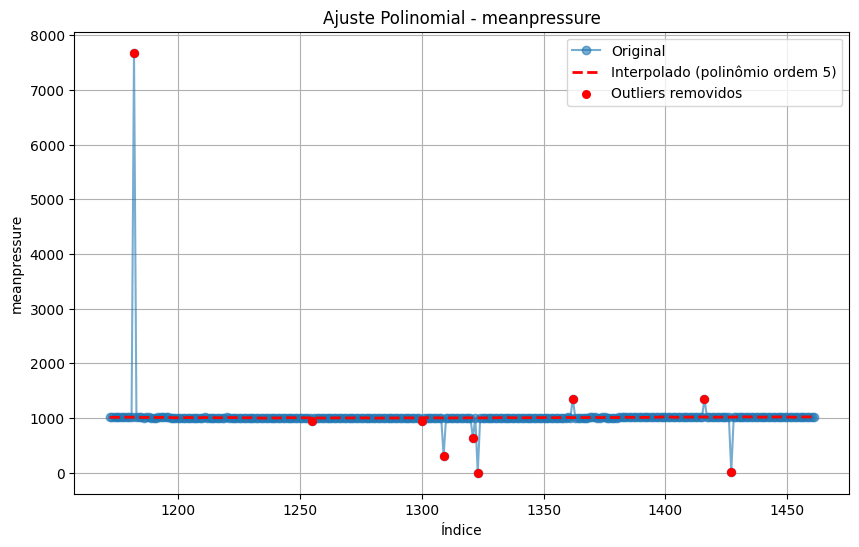

In [ ]:
# Coluna a ser analisada
col = 'meanpressure'

# Índices dos outliers
out_idx = outliers_meanpressure.index

# Escolher uma janela em torno dos outliers para visualização
# (por exemplo, 10 pontos antes e depois do primeiro outlier)
i0 = out_idx[0]
window = range(max(0, i0 - 10), len(train_ds2))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(window, train_ds[col].iloc[window], 'o-', label='Original', alpha=0.6)
plt.plot(window, train_ds2[col].iloc[window], 'r--', label='Interpolado (polinômio ordem 5)', linewidth=2)

# Destacar os outliers
plt.scatter(out_idx, train_ds[col].iloc[out_idx], color='red', s=30, label='Outliers removidos', zorder=5)

plt.title(f"Ajuste Polinomial - {col}")
plt.xlabel("Índice")
plt.ylabel(col)
plt.legend()
plt.grid(True)
plt.show()


## Teste de estacionariedade

* ADF : H_0 : A série é não estacionária
* KPSS : H_0 : A série é estacionária

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series, name=""):
    series = series.dropna()

    adf_result = adfuller(series)
    kpss_result = kpss(series, regression='c', nlags='auto')

    print(f"\nResultados para: {name}")

    print("\nADF Test:")
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")

    print("\nKPSS Test:")
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")


In [ ]:
stationarity_tests(train_ds2['meanpressure'], "meanpressure")


Resultados para: meanpressure

ADF Test:
ADF Statistic: -2.1555
p-value: 0.2228

KPSS Test:
KPSS Statistic: 0.0940
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [ ]:
stationarity_tests(train_ds2['meantemp'], "meantemp")


Resultados para: meantemp

ADF Test:
ADF Statistic: -2.0216
p-value: 0.2772

KPSS Test:
KPSS Statistic: 0.1890
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [ ]:
stationarity_tests(train_ds2['humidity'], "humidity")


Resultados para: humidity

ADF Test:
ADF Statistic: -3.6822
p-value: 0.0044

KPSS Test:
KPSS Statistic: 0.0934
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


In [ ]:
stationarity_tests(train_ds2['wind_speed'], "wind_speed")


Resultados para: wind_speed

ADF Test:
ADF Statistic: -3.8378
p-value: 0.0025

KPSS Test:
KPSS Statistic: 0.1400
p-value: 0.1000


/tmp/ipython-input-3187613491.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


Os testes indicam que wind_speed e humidity são estacionárias

Entretanto, houve discordância entre os testes sobre a estacionariedade de meantemp e meanpressure. Provavelmente possue fraca tendência, sazonalidade ou são quase estacionárias;

## Análise Exploratória


### Gráficos

In [ ]:
train_ds2.shape

(1462, 5)

In [ ]:
train_ds2.drop('date', axis=1).describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.499380,60.751909,6.793239,1008.248009
std,7.350568,16.768356,4.557540,7.439722
min,6.000000,13.428571,0.000000,991.375000
25%,18.857143,50.328125,3.475000,1001.625000
50%,27.714286,62.625000,6.166667,1008.563492
75%,31.308338,72.125000,9.187286,1014.875000
max,38.714286,100.000000,42.220000,1023.000000


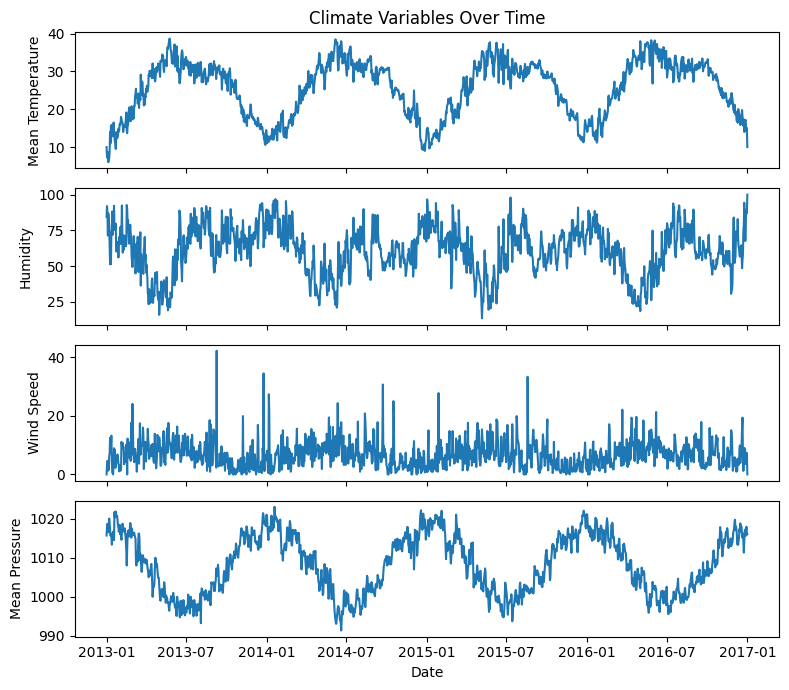

In [ ]:
# Plot das séries univariadas

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 7), sharex=True)

axes[0].plot(train_ds2['date'], train_ds2['meantemp'])
axes[0].set_ylabel('Mean Temperature')
axes[0].set_title('Climate Variables Over Time')

axes[1].plot(train_ds2['date'], train_ds2['humidity'])
axes[1].set_ylabel('Humidity')

axes[2].plot(train_ds2['date'], train_ds2['wind_speed'])
axes[2].set_ylabel('Wind Speed')

axes[3].plot(train_ds2['date'], train_ds2['meanpressure'])
axes[3].set_ylabel('Mean Pressure')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

### Análise de tendência

In [ ]:
!pip install pymannkendall

In [ ]:
import pymannkendall as mk
from scipy.stats import kruskal


In [ ]:
result = mk.original_test(train_ds2['meantemp'])
print(result)

Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(8.173825448265504e-06), z=np.float64(4.4605796981314265), Tau=np.float64(0.077865824712006), s=np.float64(83160.0), var_s=np.float64(347564898.6666667), slope=np.float64(0.0017756239208915382), intercept=np.float64(26.417192440074448))


A série meantemp possui crescente tendência fraca

In [ ]:
result = mk.original_test(train_ds2['humidity'])
print(result)


Mann_Kendall_Test(trend='decreasing', h=np.True_, p=np.float64(0.004995992991412734), z=np.float64(-2.8072920157487853), Tau=np.float64(-0.04900603094969901), s=np.float64(-52338.0), var_s=np.float64(347570148.0), slope=np.float64(-0.0030007060484819924), intercept=np.float64(64.8170157684161))


A série humidity possui tendencia decrescente fraca

In [ ]:
result = mk.original_test(train_ds2['wind_speed'])
print(result)

Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.44238538417937256), z=np.float64(-0.7681713633726763), Tau=np.float64(-0.0134102253670677), s=np.float64(-14322.0), var_s=np.float64(347560540.0), slope=np.float64(-0.00015298776097912064), intercept=np.float64(6.278424226061914))


A série wind_speed não possui tendência

In [ ]:
result = mk.original_test(train_ds2['meanpressure'])
print(result)

Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.5617344878427528), z=np.float64(0.5802671331949), Tau=np.float64(0.010130235179884475), s=np.float64(10819.0), var_s=np.float64(347566579.0), slope=np.float64(0.0002602133749674142), intercept=np.float64(1008.3734061930784))


a série mean_pressure não possui tendência

### Análise de sazonalidade

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram


#### Meantemp

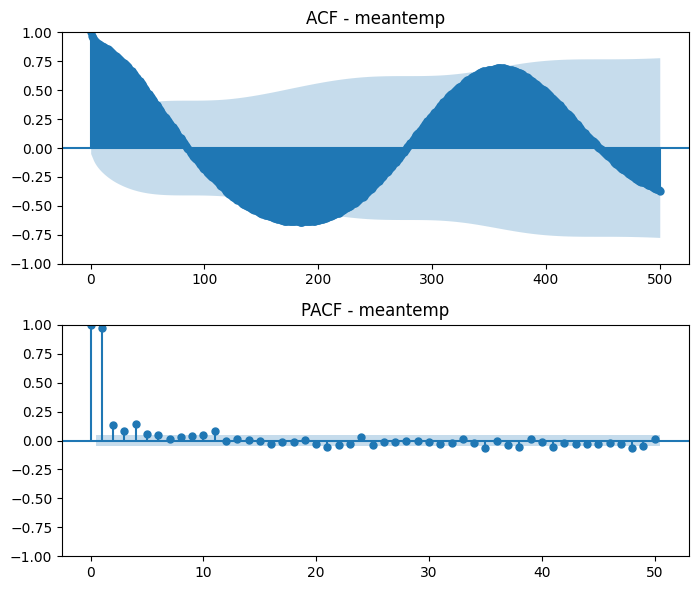

In [ ]:

serie = train_ds2['meantemp'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(7, 6))

# ACF
plot_acf(serie, lags=500, ax=axes[0])
axes[0].set_title("ACF - meantemp")

# PACF
plot_pacf(serie, lags=50, ax=axes[1], method='ywm')  # método mais estável
axes[1].set_title("PACF - meantemp")

plt.tight_layout()
plt.show()



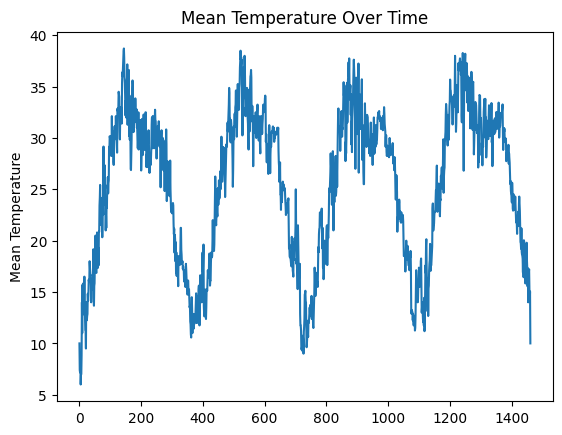

In [ ]:
plt.plot(train_ds2['meantemp'])
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature Over Time')
plt.show()

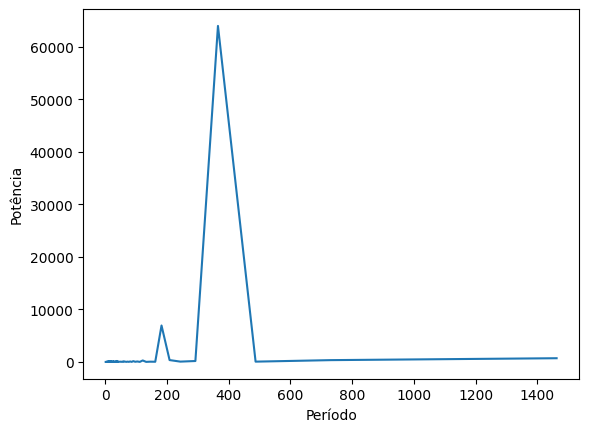

In [ ]:

series = train_ds2['meantemp'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
min_period = 60       # ajuste conforme seu caso
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]


In [ ]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95),
                      distance=10)

peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

idx = np.argsort(peak_powers)[::-1]

for p, pow_ in zip(peak_periods[idx][:5], peak_powers[idx][:5]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")


Período ≈ 365.5 | Potência = 63982.88


A série possue período de 365.5 anos

#### Humidity_no_trend

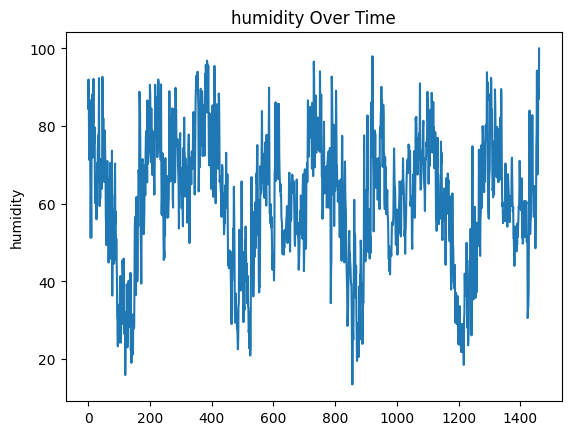

In [ ]:
plt.plot(train_ds2['humidity'])
plt.ylabel('humidity')
plt.title('humidity Over Time')
plt.show()

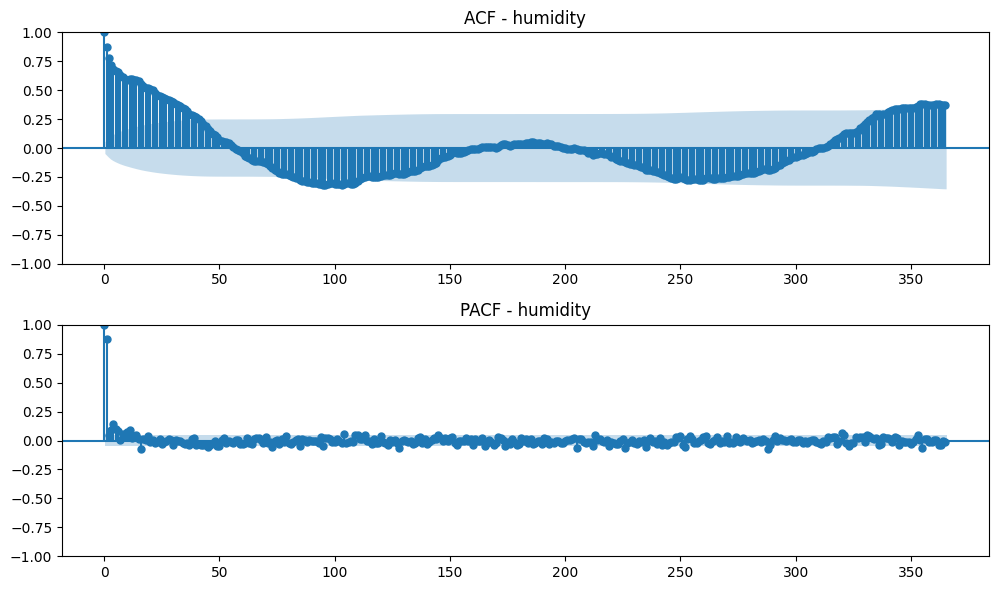

In [ ]:

serie = train_ds2['humidity'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACF
plot_acf(serie, lags=365, ax=axes[0])
axes[0].set_title("ACF - humidity")

# PACF
plot_pacf(serie, lags=365, ax=axes[1], method='ywm')  # método mais estável
axes[1].set_title("PACF - humidity")

plt.tight_layout()
plt.show()



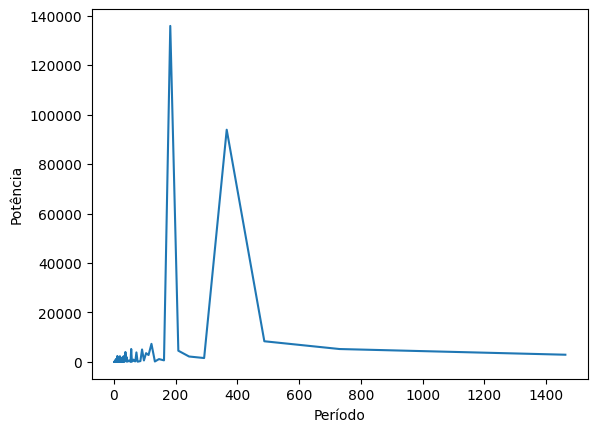

In [ ]:

series = train_ds2['humidity'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
min_period = 60       # ajuste conforme seu caso
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]


In [ ]:
from scipy.signal import find_peaks
import numpy as np

# Assumindo que power_f (potência do periodograma) e freqs_f (frequências) estão definidos.
# Substitua as linhas acima com seus dados reais, se necessário.

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95), # Filtra picos que estão acima do percentil 95
                      distance=1)                       # Garante que picos estejam separados por 10 pontos

# Calcula o período (1/frequência)
peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

# Ordena os índices em ordem decrescente de potência
idx = np.argsort(peak_powers)[::-1]

print("--- 2 Maiores Picos de Potência ---")

# Itera APENAS sobre os 2 primeiros índices ordenados [idx[:2]]
for p, pow_ in zip(peak_periods[idx][:2], peak_powers[idx][:2]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")

print("-----------------------------------")

--- 2 Maiores Picos de Potência ---
Período ≈ 182.8 | Potência = 135829.91
Período ≈ 365.5 | Potência = 93869.14
-----------------------------------


A série humidity possue dois períodos sazonais dominantes: um ciclo de meio ano e um ciclo anual;

#### wind_speed



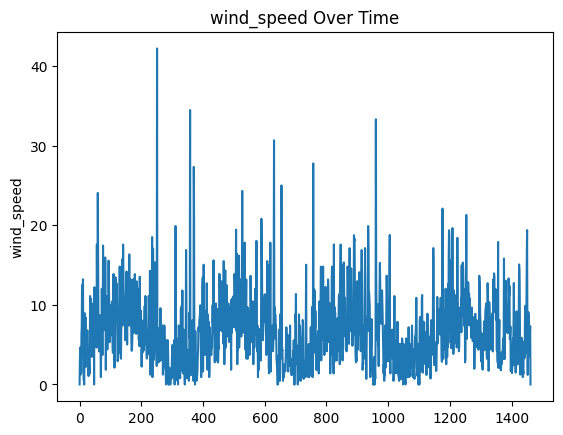

In [ ]:
plt.plot(train_ds2['wind_speed'])
plt.ylabel('wind_speed')
plt.title('wind_speed Over Time')
plt.show()

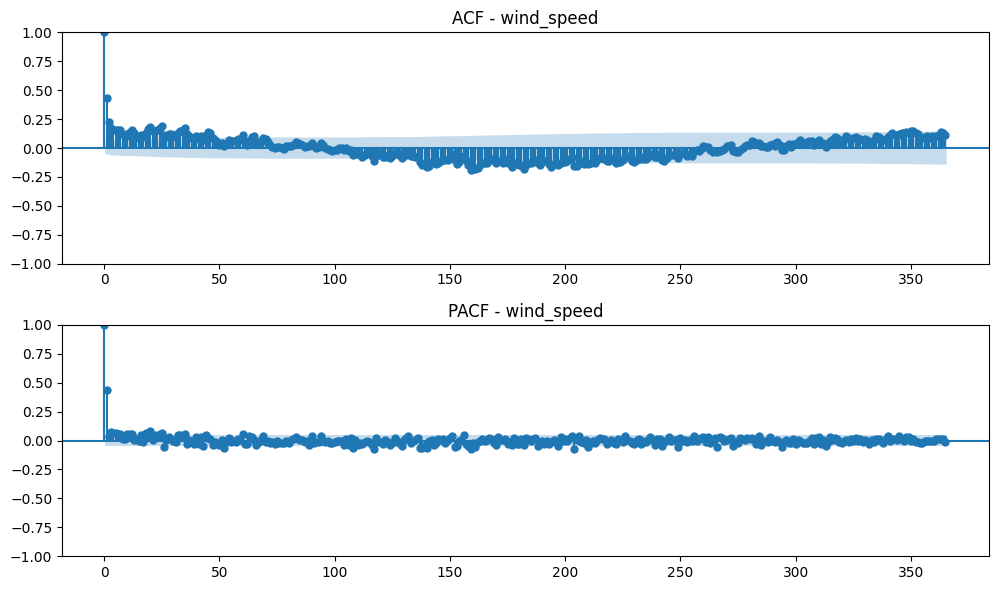

In [ ]:

serie = train_ds2['wind_speed'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACF
plot_acf(serie, lags=365, ax=axes[0])
axes[0].set_title("ACF - wind_speed")

# PACF
plot_pacf(serie, lags=365, ax=axes[1], method='ywm')  # método mais estável
axes[1].set_title("PACF - wind_speed")

plt.tight_layout()
plt.show()



acf mostra que há um comportamento sazonal

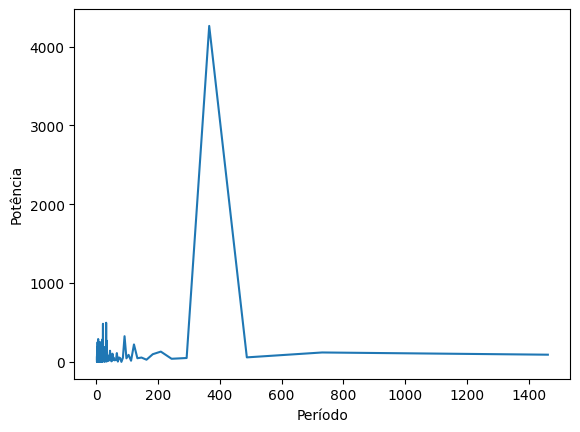

In [ ]:

series = train_ds2['wind_speed'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
min_period = 60       # ajuste conforme seu caso
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]


In [ ]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95),
                      distance=10)

peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

idx = np.argsort(peak_powers)[::-1]

for p, pow_ in zip(peak_periods[idx][:5], peak_powers[idx][:5]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")


Período ≈ 365.5 | Potência = 4261.15
Período ≈ 91.4 | Potência = 326.14


período anual

#### meanpressure

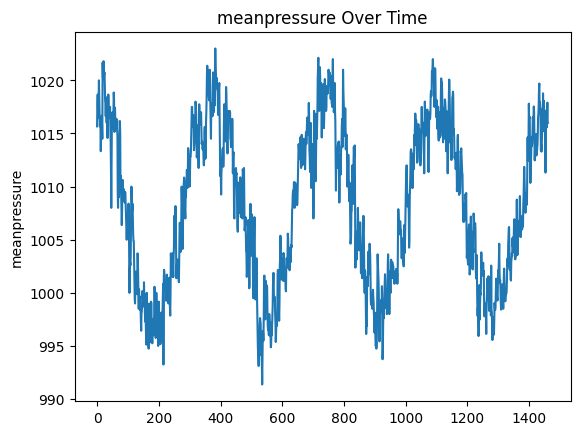

In [ ]:
plt.plot(train_ds2['meanpressure'])
plt.ylabel('meanpressure')
plt.title('meanpressure Over Time')
plt.show()

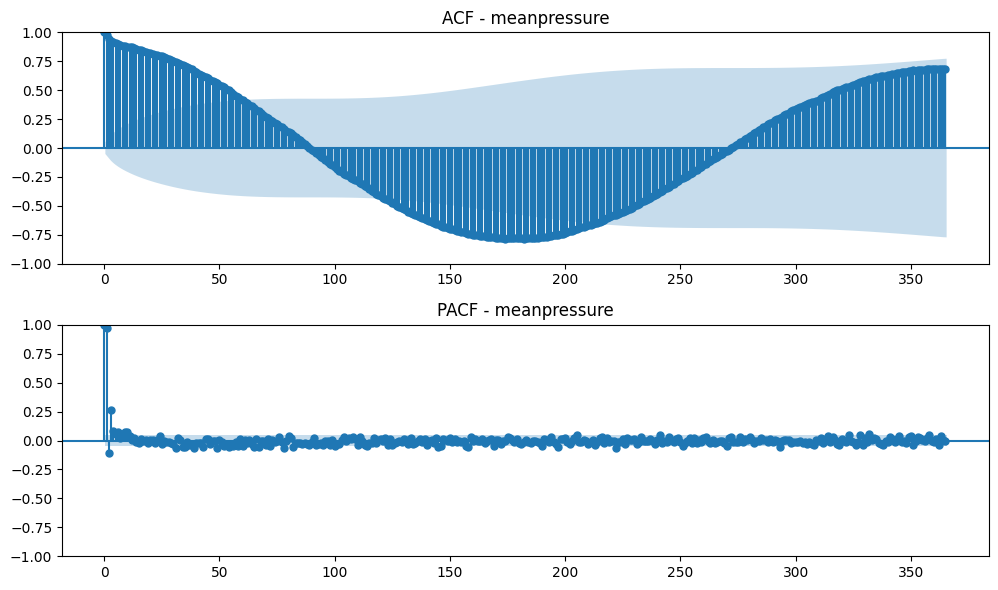

In [ ]:

serie = train_ds2['meanpressure'].dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# ACF
plot_acf(serie, lags=365, ax=axes[0])
axes[0].set_title("ACF - meanpressure")

# PACF
plot_pacf(serie, lags=365, ax=axes[1], method='ywm')  # método mais estável
axes[1].set_title("PACF - meanpressure")

plt.tight_layout()
plt.show()



acf mostra que há um comportamento sazonal

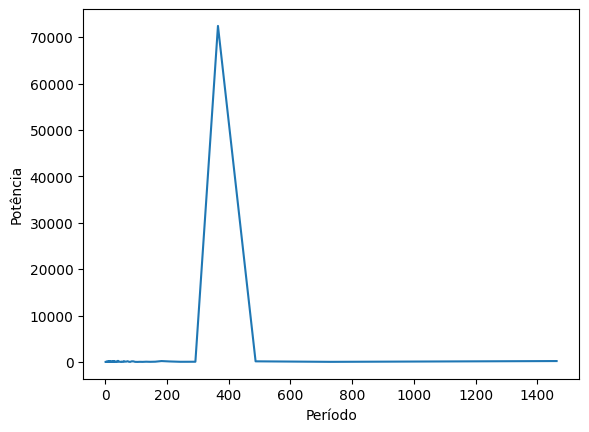

In [ ]:

series = train_ds2['meanpressure'].dropna().values
freqs, power = periodogram(series)

# evita frequência zero
freqs = freqs[1:]
power = power[1:]

dominant_freq = freqs[np.argmax(power)]
period = 1 / dominant_freq

plt.plot(1/freqs, power)
plt.xlabel("Período")
plt.ylabel("Potência")
plt.show()


In [ ]:
from scipy.signal import find_peaks

min_period = 60       # ajuste conforme seu caso
mask = (1 / freqs) >= min_period

freqs_f = freqs[mask]
power_f = power[mask]

peaks, _ = find_peaks(power_f,
                      height=np.percentile(power_f, 95),
                      distance=10)

peak_periods = 1 / freqs_f[peaks]
peak_powers = power_f[peaks]

idx = np.argsort(peak_powers)[::-1]

for p, pow_ in zip(peak_periods[idx][:5], peak_powers[idx][:5]):
    print(f"Período ≈ {p:.1f} | Potência = {pow_:.2f}")


Período ≈ 365.5 | Potência = 72412.00


###sssss

In [ ]:
# Calculate descriptive statistics for the series
train_ds_numeric = train_ds2.drop('date', axis=1)
mean_stats = train_ds_numeric.mean()
std_dev_stats = train_ds_numeric.std()
skewness_stats = train_ds_numeric.skew()
kurtosis_stats = train_ds_numeric.kurtosis()

print("Mean of original series:")
print(mean_stats)

print("\nStandard Deviation of original series:")
print(std_dev_stats)

print("\nSkewness of original series:")
print(skewness_stats)

print("\nKurtosis of original series:")
print(kurtosis_stats)

Mean of original series:
meantemp          25.499380
humidity          60.751909
wind_speed         6.793239
meanpressure    1008.248009
dtype: float64

Standard Deviation of original series:
meantemp         7.350568
humidity        16.768356
wind_speed       4.557540
meanpressure     7.439722
dtype: float64

Skewness of original series:
meantemp       -0.446187
humidity       -0.343858
wind_speed      1.442301
meanpressure   -0.062831
dtype: float64

Kurtosis of original series:
meantemp       -0.937749
humidity       -0.310290
wind_speed      5.077359
meanpressure   -1.252409
dtype: float64


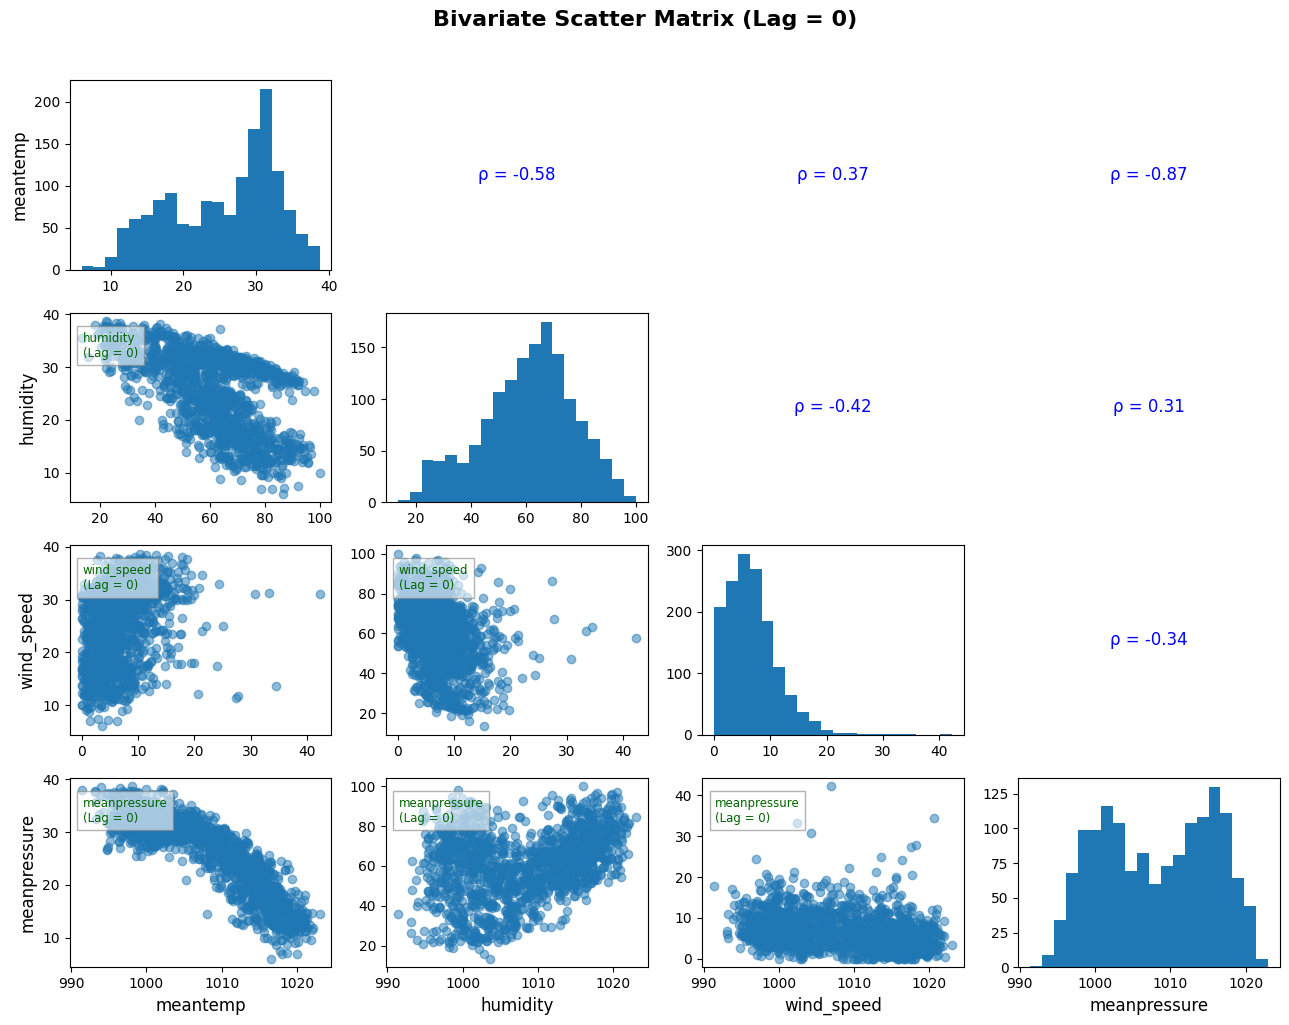

In [ ]:
plot_bivariate_scatter(train_ds2.drop('date', axis=1), lag=0, size=(13,10))

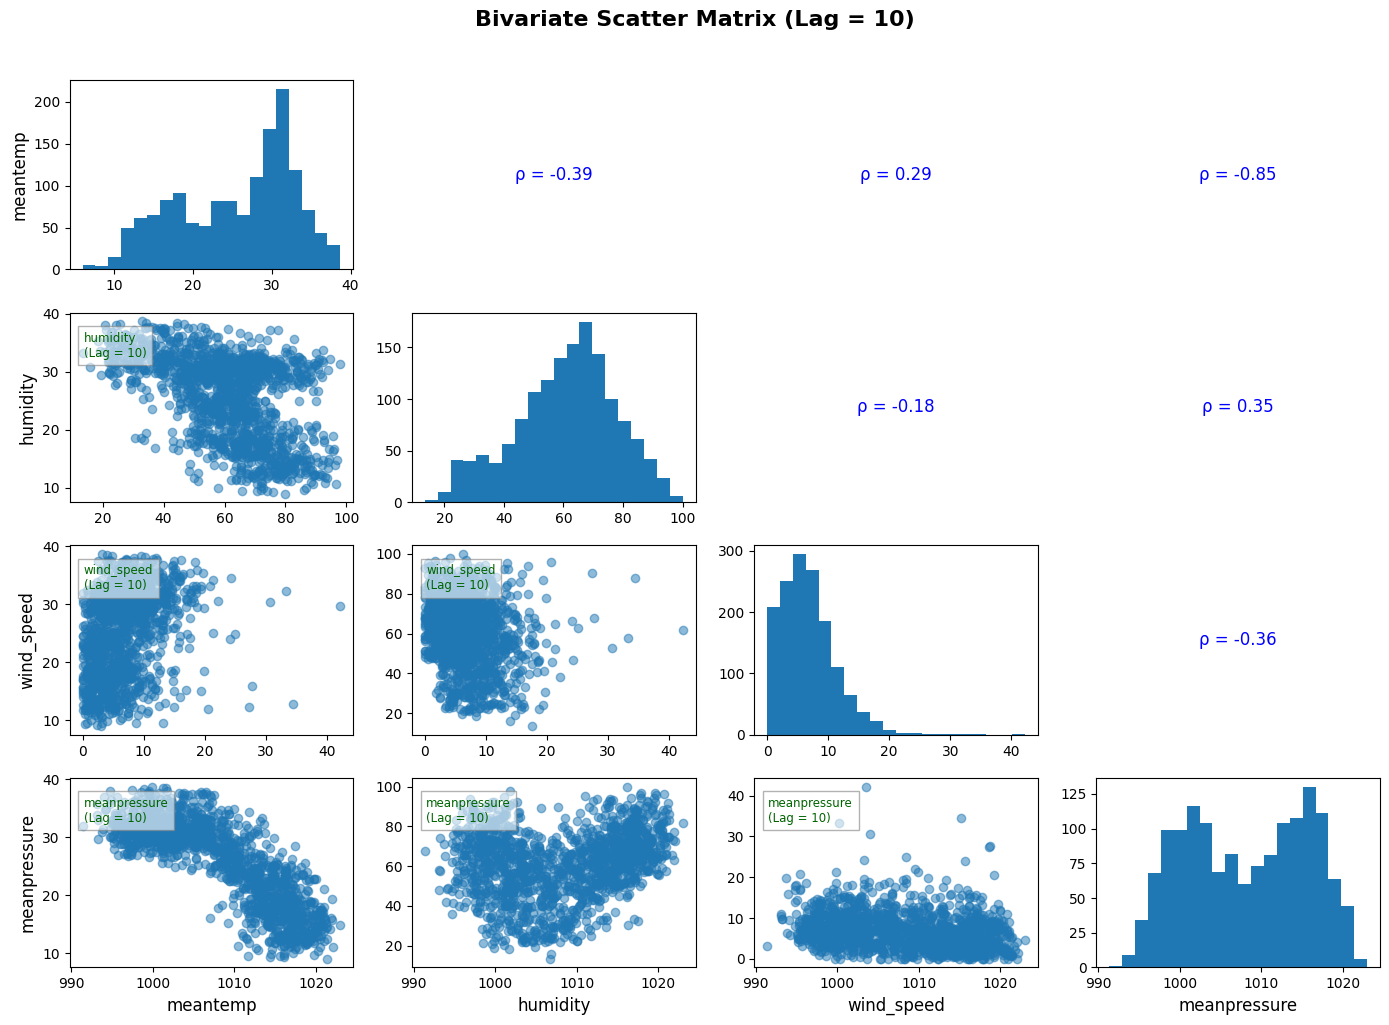

In [ ]:
plot_bivariate_scatter(train_ds2.drop('date', axis=1), lag=10, size=(14,10))

### Analisando humidity x meantemp

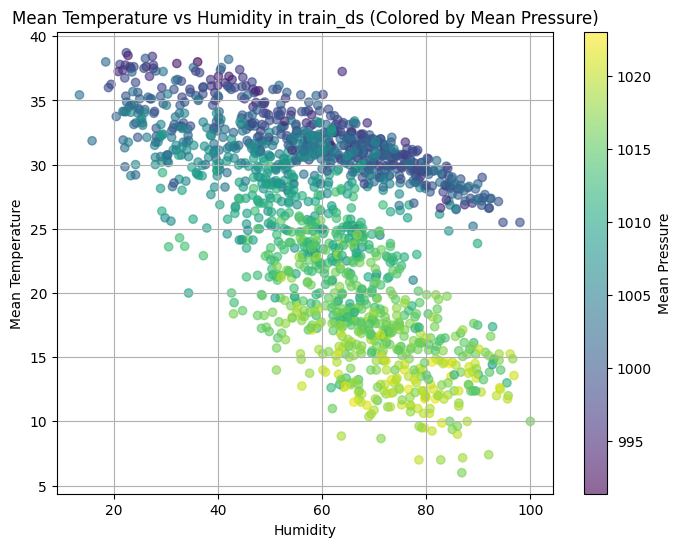

In [ ]:
plt.figure(figsize=(8, 6))

# Create a scatter plot with color mapping based on 'meanpressure'
scatter = plt.scatter(train_ds2['humidity'], train_ds2['meantemp'], c=train_ds2['meanpressure'], cmap='viridis', alpha=0.6)

plt.xlabel('Humidity')
plt.ylabel('Mean Temperature')
plt.title('Mean Temperature vs Humidity in train_ds (Colored by Mean Pressure)')
plt.colorbar(scatter, label='Mean Pressure') # Add a color bar to show the mapping
plt.grid(True)
plt.show()

como dito anteriormente, é possível observar duas nuvens de pontos distintas

Threshold T for meanpressure: 1007.5714


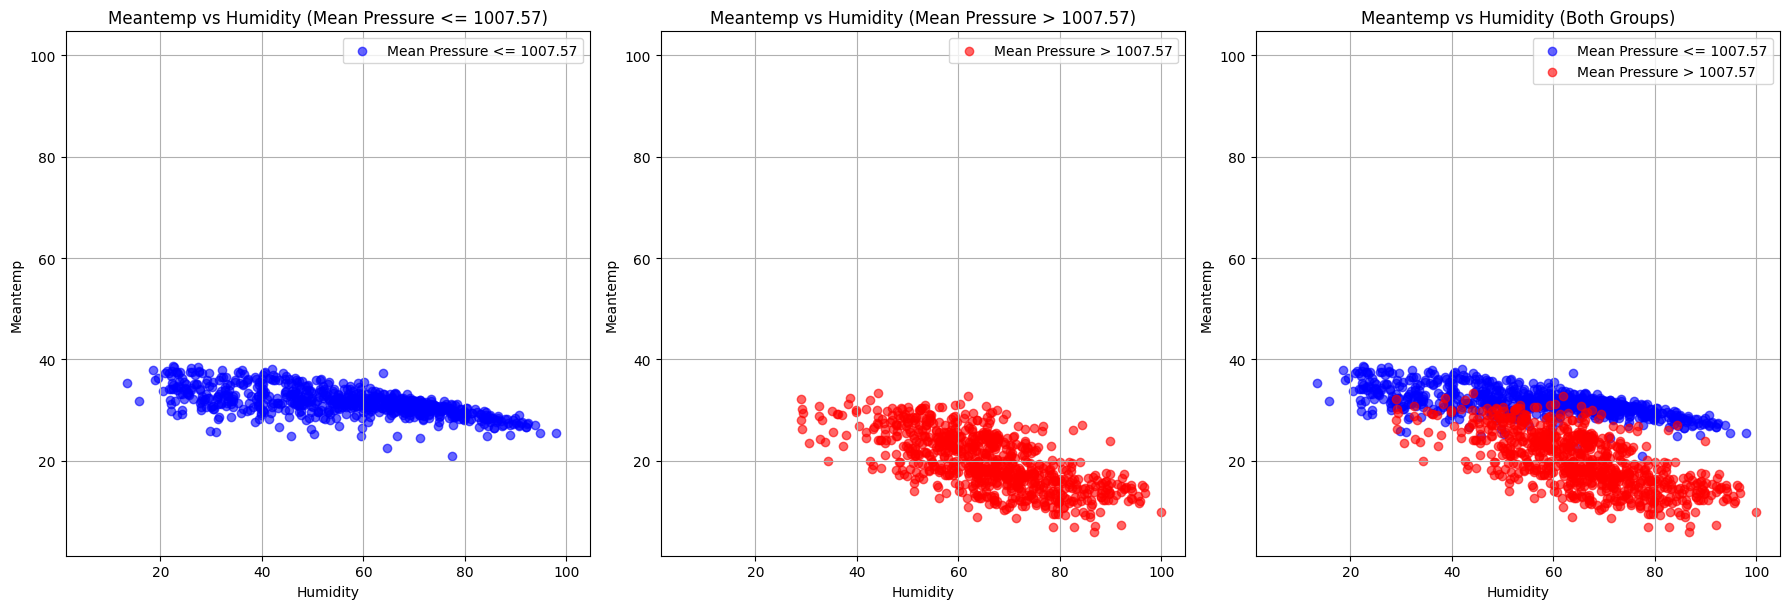

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the threshold T as the median of meanpressure in train_ds2
T = train_ds2['meanpressure'].median()
T = 1007.5714
print(f"Threshold T for meanpressure: {T:.4f}")

# Create a boolean mask based on the threshold
pressure_condition = train_ds2['meanpressure'] <= T

# Define the two groups based on the pressure condition
group_low_pressure = train_ds2[pressure_condition]
group_high_pressure = train_ds2[~pressure_condition]

# Choose the variables for the scatter plot
x_variable = 'humidity'
y_variable = 'meantemp'

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6)) # Adjusted figure size for three side-by-side plots

# Plot for Mean Pressure <= T
axes[0].scatter(group_low_pressure[x_variable], group_low_pressure[y_variable], color='blue', alpha=0.6, label=f'Mean Pressure <= {T:.2f}')
axes[0].set_xlabel(x_variable.capitalize())
axes[0].set_ylabel(y_variable.capitalize())
axes[0].set_title(f'{y_variable.capitalize()} vs {x_variable.capitalize()} (Mean Pressure <= {T:.2f})')
axes[0].grid(True)
axes[0].legend()


# Plot for Mean Pressure > T
axes[1].scatter(group_high_pressure[x_variable], group_high_pressure[y_variable], color='red', alpha=0.6, label=f'Mean Pressure > {T:.2f}')
axes[1].set_xlabel(x_variable.capitalize())
axes[1].set_ylabel(y_variable.capitalize())
axes[1].set_title(f'{y_variable.capitalize()} vs {x_variable.capitalize()} (Mean Pressure > {T:.2f})')
axes[1].grid(True)
axes[1].legend()


# Plot both groups together
axes[2].scatter(group_low_pressure[x_variable], group_low_pressure[y_variable], color='blue', alpha=0.6, label=f'Mean Pressure <= {T:.2f}')
axes[2].scatter(group_high_pressure[x_variable], group_high_pressure[y_variable], color='red', alpha=0.6, label=f'Mean Pressure > {T:.2f}')
axes[2].set_xlabel(x_variable.capitalize())
axes[2].set_ylabel(y_variable.capitalize())
axes[2].set_title(f'{y_variable.capitalize()} vs {x_variable.capitalize()} (Both Groups)')
axes[2].legend()
axes[2].grid(True)


# Optional: Set equal limits for all subplots for better comparison
all_data_x = train_ds2[x_variable]
all_data_y = train_ds2[y_variable]
max_limit = max(all_data_x.max(), all_data_y.max())
min_limit = min(all_data_x.min(), all_data_y.min())

buffer = (max_limit - min_limit) * 0.05
for ax in axes:
    ax.set_xlim(min_limit - buffer, max_limit + buffer)
    ax.set_ylim(min_limit - buffer, max_limit + buffer)
    ax.set_aspect('equal', adjustable='box') # Ensure aspect ratio is equal


plt.tight_layout()
plt.show()

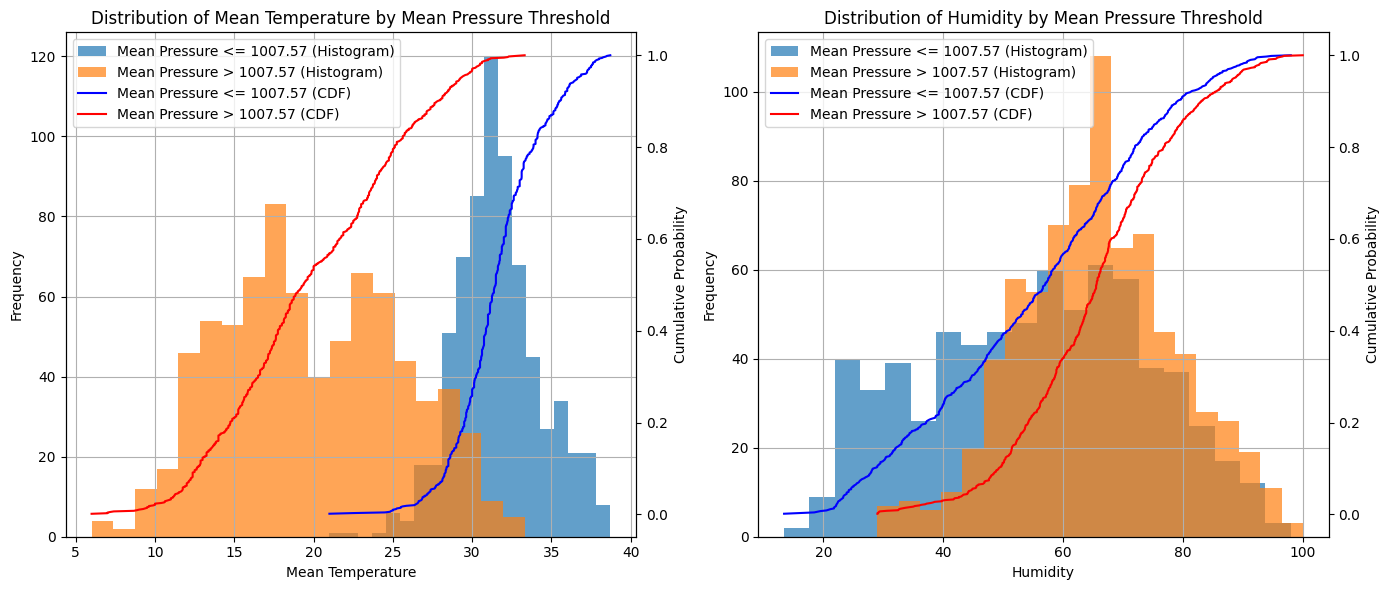

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming T and pressure_condition are already defined from previous cells
# Define the two groups based on the pressure condition
group_low_pressure = train_ds2[pressure_condition]
group_high_pressure = train_ds2[~pressure_condition]

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6)) # Adjusted figure size for side-by-side plots

# Plot overlaid histograms for 'meantemp' on the first subplot
axes[0].hist(group_low_pressure['meantemp'].dropna(), bins=20, alpha=0.7, label=f'Mean Pressure <= {T:.2f} (Histogram)')
axes[0].hist(group_high_pressure['meantemp'].dropna(), bins=20, alpha=0.7, label=f'Mean Pressure > {T:.2f} (Histogram)')
axes[0].set_xlabel('Mean Temperature')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Mean Temperature by Mean Pressure Threshold')
axes[0].grid(True)

# Add a secondary y-axis for the CDF
ax2_meantemp = axes[0].twinx()
# Calculate and plot the CDF for the low pressure group
sorted_meantemp_low = np.sort(group_low_pressure['meantemp'].dropna())
cdf_low_meantemp = np.arange(1, len(sorted_meantemp_low) + 1) / len(sorted_meantemp_low)
ax2_meantemp.plot(sorted_meantemp_low, cdf_low_meantemp, color='blue', linestyle='-', label=f'Mean Pressure <= {T:.2f} (CDF)')

# Calculate and plot the CDF for the high pressure group
sorted_meantemp_high = np.sort(group_high_pressure['meantemp'].dropna())
cdf_high_meantemp = np.arange(1, len(sorted_meantemp_high) + 1) / len(sorted_meantemp_high)
ax2_meantemp.plot(sorted_meantemp_high, cdf_high_meantemp, color='red', linestyle='-', label=f'Mean Pressure > {T:.2f} (CDF)')

ax2_meantemp.set_ylabel('Cumulative Probability')
# Combine legends from both axes
lines, labels = axes[0].get_legend_handles_labels()
lines2, labels2 = ax2_meantemp.get_legend_handles_labels()
ax2_meantemp.legend(lines + lines2, labels + labels2, loc='best')


# Plot overlaid histograms for 'humidity' on the second subplot
axes[1].hist(group_low_pressure['humidity'].dropna(), bins=20, alpha=0.7, label=f'Mean Pressure <= {T:.2f} (Histogram)')
axes[1].hist(group_high_pressure['humidity'].dropna(), bins=20, alpha=0.7, label=f'Mean Pressure > {T:.2f} (Histogram)')
axes[1].set_xlabel('Humidity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Humidity by Mean Pressure Threshold')
axes[1].grid(True)

# Add a secondary y-axis for the CDF
ax2_humidity = axes[1].twinx()
# Calculate and plot the CDF for the low pressure group
sorted_humidity_low = np.sort(group_low_pressure['humidity'].dropna())
cdf_low_humidity = np.arange(1, len(sorted_humidity_low) + 1) / len(sorted_humidity_low)
ax2_humidity.plot(sorted_humidity_low, cdf_low_humidity, color='blue', linestyle='-', label=f'Mean Pressure <= {T:.2f} (CDF)')

# Calculate and plot the CDF for the high pressure group
sorted_humidity_high = np.sort(group_high_pressure['humidity'].dropna())
cdf_high_humidity = np.arange(1, len(sorted_humidity_high) + 1) / len(sorted_humidity_high)
ax2_humidity.plot(sorted_humidity_high, cdf_high_humidity, color='red', linestyle='-', label=f'Mean Pressure > {T:.2f} (CDF)')

ax2_humidity.set_ylabel('Cumulative Probability')
# Combine legends from both axes
lines, labels = axes[1].get_legend_handles_labels()
lines2, labels2 = ax2_humidity.get_legend_handles_labels()
ax2_humidity.legend(lines + lines2, labels + labels2, loc='best')


plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import levene, bartlett
from statsmodels.api import OLS, add_constant

# --- Levene e Bartlett: igualdade de variâncias nos resíduos ---
print("=== Testes de Igualdade de Variâncias ===")

# Define X_low, y_low, X_high, and y_high
X_low = group_low_pressure['humidity'].values.reshape(-1, 1)
y_low = group_low_pressure['meantemp'].values
X_high = group_high_pressure['humidity'].values.reshape(-1, 1)
y_high = group_high_pressure['meantemp'].values

# Use os resíduos de cada grupo (já calculados anteriormente)
# Recalculate residuals based on the defined X and y
reg_low = OLS(y_low, add_constant(X_low)).fit()
reg_high = OLS(y_high, add_constant(X_high)).fit()

resid_low = reg_low.resid
resid_high = reg_high.resid


# Teste de Levene (menos sensível à não normalidade)
stat_levene, p_levene = levene(resid_low, resid_high, center='median')
print(f"Levene Test:  stat = {stat_levene:.4f},  p-value = {p_levene:.4f}")

# Teste de Bartlett (assume normalidade)
stat_bartlett, p_bartlett = bartlett(resid_low, resid_high)
print(f"Bartlett Test: stat = {stat_bartlett:.4f},  p-value = {p_bartlett:.4f}")

print("\n=== Teste de Chow: mudança estrutural na regressão ===")

# --- Teste de Chow ---
# Combina os dois conjuntos
combined_X = np.concatenate([X_low, X_high])
combined_y = np.concatenate([y_low, y_high])

# Adiciona constante (intercepto)
combined_X_const = add_constant(combined_X)
X_low_const = add_constant(X_low)
X_high_const = add_constant(X_high)

# Regressões separadas
ols_low = OLS(y_low, X_low_const).fit()
ols_high = OLS(y_high, X_high_const).fit()

# Regressão conjunta
ols_pooled = OLS(combined_y, combined_X_const).fit()

# Soma dos quadrados dos resíduos
SSR_pooled = np.sum(ols_pooled.resid ** 2)
SSR_low = np.sum(ols_low.resid ** 2)
SSR_high = np.sum(ols_high.resid ** 2)

# Graus de liberdade
k = X_low_const.shape[1]  # número de parâmetros (inclui intercepto)
n_low = len(y_low)
n_high = len(y_high)

# Estatística F do teste de Chow
numerator = (SSR_pooled - (SSR_low + SSR_high)) / k
denominator = (SSR_low + SSR_high) / (n_low + n_high - 2 * k)
F_chow = numerator / denominator

from scipy.stats import f
p_chow = 1 - f.cdf(F_chow, k, n_low + n_high - 2 * k)

print(f"Chow Test: F = {F_chow:.4f},  p-value = {p_chow:.4f}")

# Interpretação resumida
print("\n--- Interpretação ---")
if p_levene < 0.05:
    print("→ Levene: rejeita H0, as variâncias dos resíduos são diferentes entre os grupos.")
else:
    print("→ Levene: não rejeita H0, variâncias semelhantes.")

if p_chow < 0.05:
    print("→ Chow: rejeita H0, há diferença significativa entre as regressões (estrutura mudou).")
else:
    print("→ Chow: não rejeita H0, as regressões podem ser consideradas equivalentes.")

=== Testes de Igualdade de Variâncias ===
Levene Test:  stat = 274.9143,  p-value = 0.0000
Bartlett Test: stat = 297.1391,  p-value = 0.0000

=== Teste de Chow: mudança estrutural na regressão ===
Chow Test: F = 1620.8985,  p-value = 0.0000

--- Interpretação ---
→ Levene: rejeita H0, as variâncias dos resíduos são diferentes entre os grupos.
→ Chow: rejeita H0, há diferença significativa entre as regressões (estrutura mudou).


ou seja, podemos considerar que são 2 grupos diferentes com características próprias

# Fourier + ARIMA

In [ ]:
from sklearn.metrics import mean_squared_error

# 1. Preprocess test_ds (similar to train_ds2)
test_ds2 = test_ds.copy()

# Identify and interpolate outliers in 'meanpressure' using robust_zscore
z_test = robust_zscore(test_ds2['meanpressure'])
outliers_meanpressure_test = test_ds2[np.abs(z_test) > 3.5]

# Set outliers to NaN
test_ds2.loc[outliers_meanpressure_test.index, 'meanpressure'] = np.nan

# Interpolate the 'meanpressure' column (order 5 polynomial, as used for train_ds2)
# Ensure 'date' is set as index temporarily for interpolation if it helps, or interpolate directly
test_ds2['meanpressure'] = test_ds2['meanpressure'].interpolate(method='polynomial', order=5)

# Ensure no NaNs remain after interpolation for edge cases
test_ds2['meanpressure'] = test_ds2['meanpressure'].fillna(method='bfill').fillna(method='ffill')

/tmp/ipython-input-28296245.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_ds2['meanpressure'] = test_ds2['meanpressure'].fillna(method='bfill').fillna(method='ffill')


In [ ]:
import numpy as np

def fourier_terms(t, period, K):
    """
    t: array-like do índice do tempo (0, 1, 2, ..., n-1)
    period: período sazonal (ex: 365)
    K: número de pares de Fourier (harmônicos)
    """
    t = np.asarray(t)
    X = []
    for k in range(1, K+1):
        X.append(np.sin(2 * np.pi * k * t / period))
        X.append(np.cos(2 * np.pi * k * t / period))
    return np.column_stack(X)


In [ ]:
k = 3

t = np.arange(len(train_ds2['meantemp']))  # índice do tempo

fourier = fourier_terms(
    t=t,
    period=365,
    K=k
)

# Construct X_full with only Fourier terms to avoid multicollinearity issues initially
X_full = fourier


In [ ]:
import statsmodels.api as sm

# --- Preparação dos Dados ---
# 1. Variável Dependente (Y)
Y = train_ds2['meantemp']

# 2. Variáveis Independentes (X)
X_com_intercepto = sm.add_constant(X_full, prepend=False)


# --- Ajuste do Modelo OLS ---
modelo_ols = sm.OLS(Y, X_com_intercepto)
resultados_ols = modelo_ols.fit()

# --- Visualização dos Resultados ---
print(resultados_ols.summary())

# Se você quiser apenas a curva ajustada (o fitted value, ou Y_hat):
curva_ajustada_ols = resultados_ols.fittedvalues

                            OLS Regression Results                            
Dep. Variable:               meantemp   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     2232.
Date:                Tue, 16 Dec 2025   Prob (F-statistic):               0.00
Time:                        23:19:55   Log-Likelihood:                -3292.5
No. Observations:                1462   AIC:                             6599.
Df Residuals:                    1455   BIC:                             6636.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6908      0.085     -8.094      0.0

*  Durbin-Watson 0.523 - mostra que há autocorrelação nos resíduos;
* Omnibus / Jarque-Bera 0.288 - não rejeita a hipótese de que os resíduos são normalmente distribuídos
* Cond. No. 1.42 - sem multicolinearidade


para tratar a autocorrelação, usaremos o arima

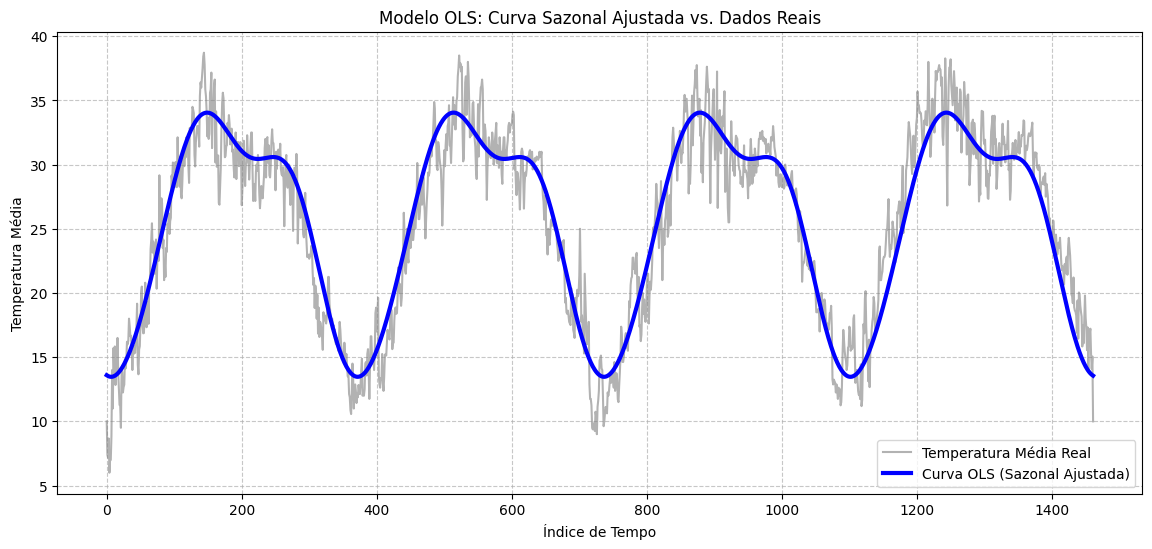

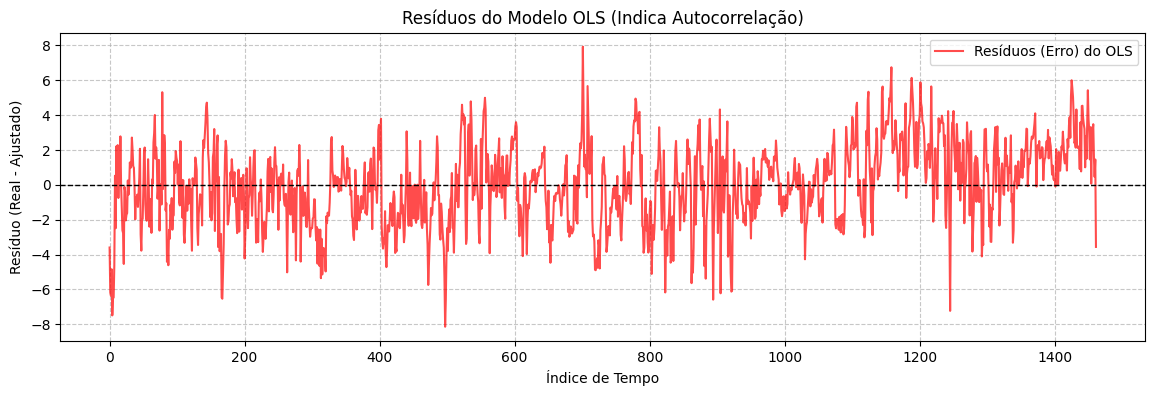

In [ ]:
# --- Dados do Modelo ---
# Resíduos (o que o modelo NÃO conseguiu explicar)
residuos_ols = resultados_ols.resid

# Curva Ajustada (a soma dos Senos/Cossenos ponderada pelos coeficientes)
curva_ajustada_ols = resultados_ols.fittedvalues

# Série Original (para comparação)
serie_original = Y

# =======================================================
# GRÁFICO 1: Série Original vs. Curva Sazonal Ajustada
# =======================================================

plt.figure(figsize=(14, 6))
plt.plot(serie_original.index, serie_original, label='Temperatura Média Real',
         color='gray', alpha=0.6)
plt.plot(serie_original.index, curva_ajustada_ols, label='Curva OLS (Sazonal Ajustada)',
         color='blue', linewidth=3)

plt.title('Modelo OLS: Curva Sazonal Ajustada vs. Dados Reais')
plt.xlabel('Índice de Tempo')
plt.ylabel('Temperatura Média')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# =======================================================
# GRÁFICO 2: Resíduos do Modelo OLS
# =======================================================

plt.figure(figsize=(14, 4))
plt.plot(serie_original.index, residuos_ols, label='Resíduos (Erro) do OLS',
         color='red', alpha=0.7)

# Linha zero para referência
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.title('Resíduos do Modelo OLS (Indica Autocorrelação)')
plt.xlabel('Índice de Tempo')
plt.ylabel('Resíduo (Real - Ajustado)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import itertools

# ==============================================================================
# 1. PREPARAÇÃO
# ==============================================================================
y_clean = Y.copy()
y_clean = y_clean.replace([np.inf, -np.inf], np.nan).dropna()
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_clean.values.reshape(-1, 1)).flatten()

# Preparar X (Fourier)
if hasattr(X_full, 'columns') and 'const' in X_full.columns:
    X_clean = X_full.drop(columns=['const'])
else:
    X_clean = X_full

X_clean = X_clean[:len(y_clean)]
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X_clean)

In [ ]:
# ==============================================================================
# 2. SUBSTITUINDO O AUTO_ARIMA (GRID SEARCH MANUAL)
# ==============================================================================
print("\n--- Iniciando Busca Manual do Melhor Modelo (Joint Estimation) ---")

# Define os intervalos de p e q (0 a 3)
p_values = range(0, 3)
q_values = range(0, 10)
pdq_combinations = list(itertools.product([3], [0], [3])) # d=0 fixo

best_aic = float("inf")
best_order = None
best_model_result = None

print(f"Testando {len(pdq_combinations)} combinações...")

for order in pdq_combinations:
    try:
        # Ajusta o SARIMAX diretamente
        model = SARIMAX(
            endog=y_scaled,
            exog=X_scaled,
            order=order,
            trend='c', # Inclui intercepto
            enforce_stationarity=False,
            enforce_invertibility=False,
            simple_differencing=False
        )

        # Otimização
        model_fit = model.fit(disp=False, method='lbfgs', maxiter=200)

        # Se o AIC for válido e melhor que o atual, salvamos
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model_result = model_fit
            print(f"Novo melhor: ARIMA{order} - AIC:{best_aic:.2f}")

    except:
        continue

print(f"\n🏆 VENCEDOR: ARIMA{best_order} com AIC: {best_aic:.2f}")
print(best_model_result.summary())


--- Iniciando Busca Manual do Melhor Modelo (Joint Estimation) ---
Testando 1 combinações...
Novo melhor: ARIMA(3, 0, 3) - AIC:-405.04

🏆 VENCEDOR: ARIMA(3, 0, 3) com AIC: -405.04
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1462
Model:               SARIMAX(3, 0, 3)   Log Likelihood                 216.519
Date:                Tue, 16 Dec 2025   AIC                           -405.039
Time:                        23:26:21   BIC                           -331.051
Sample:                             0   HQIC                          -377.437
                               - 1462                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.

In [ ]:
# ==============================================================================
# 3. PREVISÃO (FORECAST) - AGORA USANDO O MELHOR MODELO ENCONTRADO
# ==============================================================================
n_dias = 700
ultimo_t = t[-1] # índice original
t_futuro = np.arange(ultimo_t + 1, ultimo_t + n_dias + 1)

# A. Gerar Fourier Futuro
K_fourier = k # <--- CERTIFIQUE-SE QUE ESTE É O MESMO K USADO PARA GERAR O X_FULL
fourier_futuro = fourier_terms(t=t_futuro, period=365, K=K_fourier)

# B. Escalar Fourier Futuro
X_futuro_scaled = scaler_x.transform(fourier_futuro)

# C. Previsão (Get Forecast)
forecast_object = best_model_result.get_forecast(steps=n_dias, exog=X_futuro_scaled)
pred_scaled = forecast_object.predicted_mean
conf_int_scaled = forecast_object.conf_int()

# D. Desescalar (Voltar para Celsius)
pred_real = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
# Desescalar intervalo de confiança
ci_lower = scaler_y.inverse_transform(conf_int_scaled[:, 0].reshape(-1, 1)).flatten()
ci_upper = scaler_y.inverse_transform(conf_int_scaled[:, 1].reshape(-1, 1)).flatten()

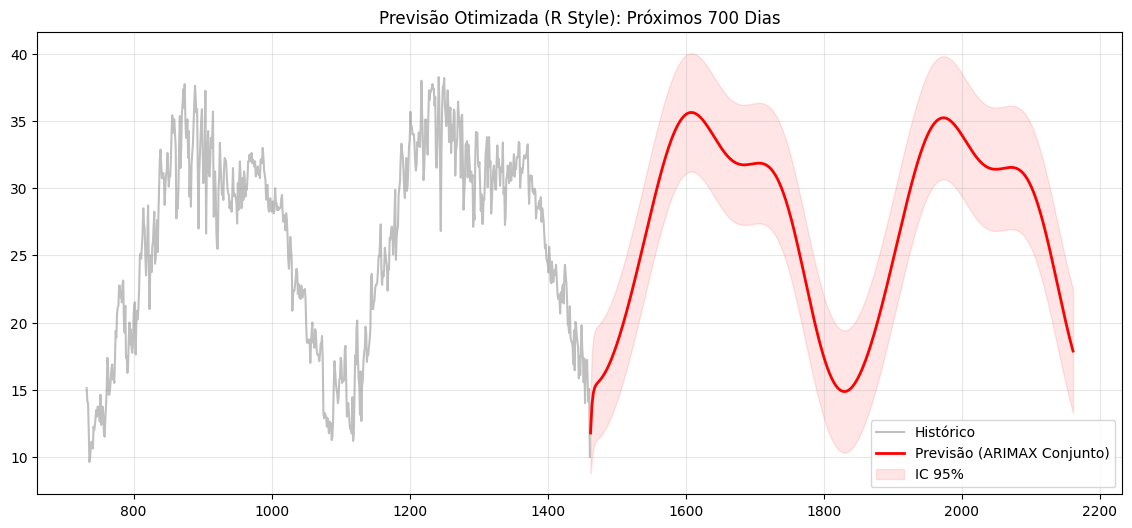

Previsão (primeiros 5 dias): [11.77736367 12.78424078 13.85335566 14.30569698 14.75094162]


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import itertools

# ==============================================================================
# 4. PLOT FINAL
# ==============================================================================
plt.figure(figsize=(14, 6))

# Dados Históricos (Últimos 2 anos para contexto)
plt.plot(t[-730:], Y.iloc[-730:], label='Histórico', color='gray', alpha=0.5)

# Previsão
plt.plot(t_futuro, pred_real, label='Previsão (ARIMAX Conjunto)', color='red', linewidth=2)

# Intervalo de Confiança
plt.fill_between(t_futuro, ci_lower, ci_upper, color='red', alpha=0.1, label='IC 95%')

plt.title(f'Previsão Otimizada (R Style): Próximos {n_dias} Dias')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Previsão (primeiros 5 dias):", pred_real[:5])

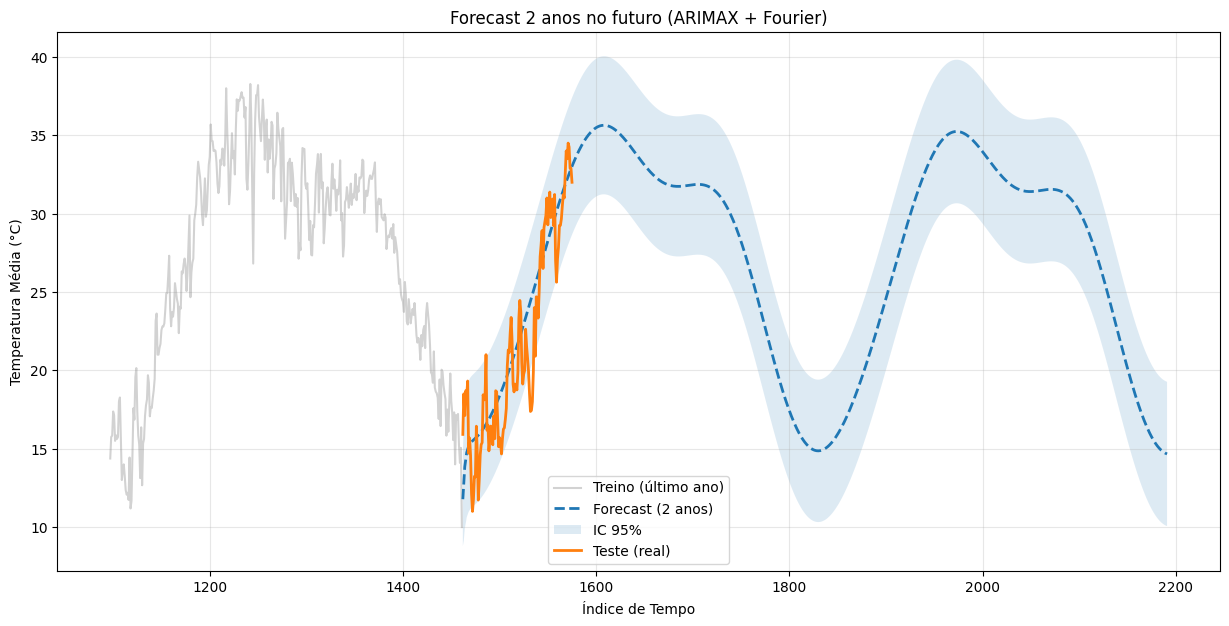

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# 1) DEFINIR HORIZONTE: 2 ANOS NO FUTURO
# ==============================================================================
steps_future = 365 * 2  # 2 anos
ultimo_t_treino = t[-1]

t_future = np.arange(ultimo_t_treino + 1, ultimo_t_treino + steps_future + 1)

# Exógenas (Fourier) para o horizonte futuro
fourier_future = fourier_terms(t=t_future, period=365, K=k)
X_future_scaled = scaler_x.transform(fourier_future)

# ==============================================================================
# 2) FORECAST 2 ANOS (com IC)
# ==============================================================================
future_obj = best_model_result.get_forecast(steps=steps_future, exog=X_future_scaled)

pred_future_scaled = future_obj.predicted_mean
ci_future_scaled = future_obj.conf_int()

# desescalar para °C
pred_future_real = scaler_y.inverse_transform(
    np.asarray(pred_future_scaled).reshape(-1, 1)
).flatten()

ci_lower = scaler_y.inverse_transform(
    np.asarray(ci_future_scaled[:, 0]).reshape(-1, 1)
).flatten()

ci_upper = scaler_y.inverse_transform(
    np.asarray(ci_future_scaled[:, 1]).reshape(-1, 1)
).flatten()

# ==============================================================================
# 3) PLOT: FORECAST + IC + TESTE SOBREPOSTO
# ==============================================================================
# Série de teste
n_dias_teste = len(test_ds2)
t_teste = np.arange(ultimo_t_treino + 1, ultimo_t_treino + n_dias_teste + 1)
y_teste_real = test_ds2['meantemp'].values

plt.figure(figsize=(15, 7))

# (opcional) mostrar só o último ano do treino
plt.plot(t[-365:], Y.iloc[-365:], label='Treino (último ano)', color='gray', alpha=0.35)

# Forecast 2 anos
plt.plot(t_future, pred_future_real, label='Forecast (2 anos)', linestyle='--', linewidth=2)

# IC 95%
plt.fill_between(t_future, ci_lower, ci_upper, alpha=0.15, label='IC 95%')

# Teste sobreposto (cai dentro do começo do forecast)
plt.plot(t_teste, y_teste_real, label='Teste (real)', linewidth=2)

plt.title('Forecast 2 anos no futuro (ARIMAX + Fourier)')
plt.xlabel('Índice de Tempo')
plt.ylabel('Temperatura Média (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# GAM

In [ ]:
!pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
from pygam import LinearGAM, s, f

In [ ]:


X = X_full      # humidity, pressure, wind_speed, Fourier, lags etc
y = Y.values    # temperatura real


In [ ]:
from pygam import LinearGAM, s

n_features = X.shape[1]

# Primeiro termo
terms = s(0, n_splines=10)

# Adiciona os demais
for i in range(1, n_features):
    terms = terms + s(i, n_splines=10)

gam = LinearGAM(terms).fit(X, y)


In [ ]:
y_pred = gam.predict(X)


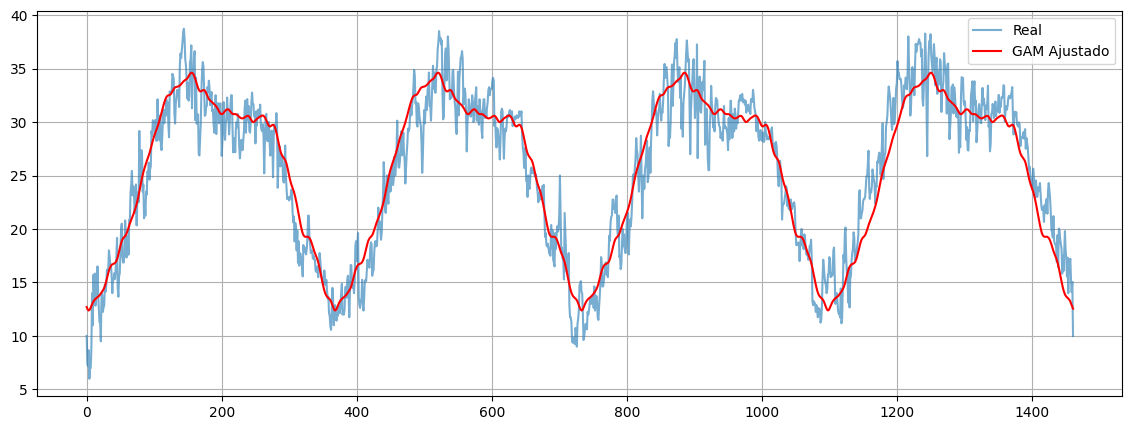

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(y, label="Real", alpha=0.6)
plt.plot(y_pred, label="GAM Ajustado", color="red")
plt.grid()
plt.legend()
plt.show()


In [ ]:
n_dias_teste = len(test_ds2)
ultimo_t_treino = len(train_ds2) - 1 # Since t starts from 0

# 1. Define o array de índice de tempo para os dados de teste
t_test = np.arange(ultimo_t_treino + 1, ultimo_t_treino + n_dias_teste + 1)

# 2. Gerar termos de Fourier para o test_ds2
K_fourier_gam = 3 # Use o mesmo K que foi usado para o treino
X_test_gam = fourier_terms(
    t=t_test,
    period=365,
    K=K_fourier_gam
)

print(f"Shape of t_test: {t_test.shape}")
print(f"Shape of X_test_gam: {X_test_gam.shape}")

Shape of t_test: (114,)
Shape of X_test_gam: (114, 6)


In [ ]:
y_pred_gam = gam.predict(X_test_gam)
print(f"Shape of y_pred_gam: {y_pred_gam.shape}")

Shape of y_pred_gam: (114,)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

y_teste_real_gam = test_ds2['meantemp'].values

# Calculate MAE
mae_gam = mean_absolute_error(y_teste_real_gam, y_pred_gam)

# Calculate RMSE
rmse_gam = math.sqrt(mean_squared_error(y_teste_real_gam, y_pred_gam))

print(f"--- GAM Model Performance on Test Set ---")
print(f"Mean Absolute Error (MAE): {mae_gam:.2f} °C")
print(f"Root Mean Squared Error (RMSE): {rmse_gam:.2f} °C")

--- GAM Model Performance on Test Set ---
Mean Absolute Error (MAE): 2.11 °C
Root Mean Squared Error (RMSE): 2.65 °C


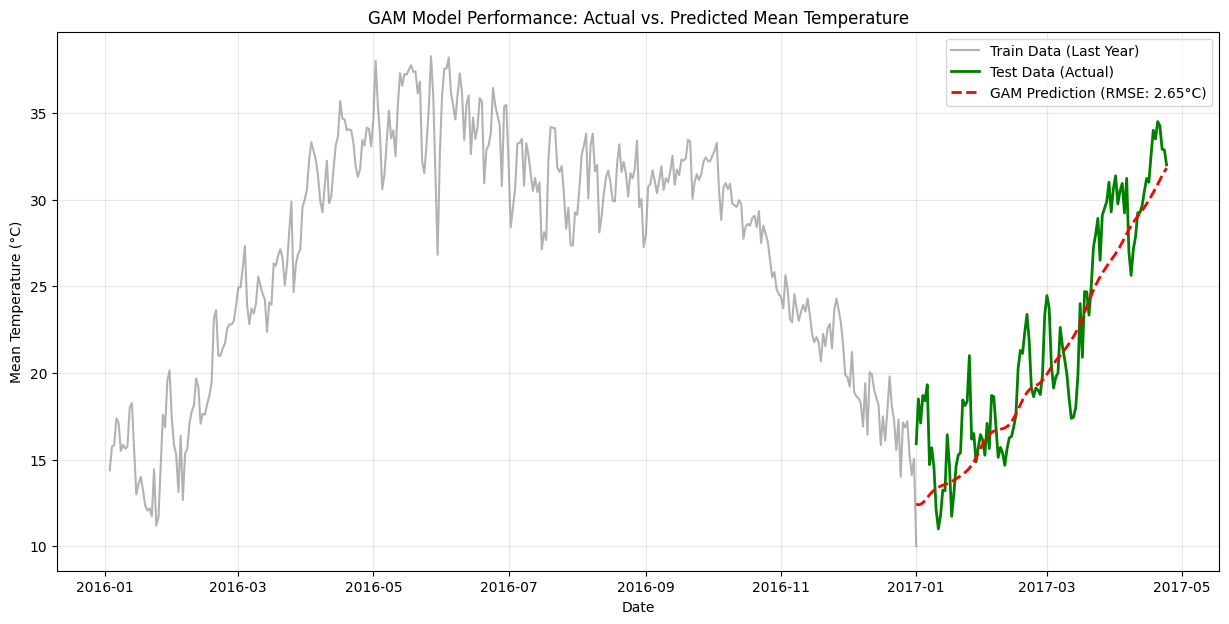

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Plot training data for context (last part)
plt.plot(train_ds2['date'].iloc[-365:], train_ds2['meantemp'].iloc[-365:], label='Train Data (Last Year)', color='gray', alpha=0.6)

# Plot actual test data
plt.plot(test_ds2['date'], y_teste_real_gam, label='Test Data (Actual)', color='green', linewidth=2)

# Plot GAM predictions
plt.plot(test_ds2['date'], y_pred_gam, label=f'GAM Prediction (RMSE: {rmse_gam:.2f}°C)', color='red', linestyle='--', linewidth=2)

plt.title('GAM Model Performance: Actual vs. Predicted Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
n_dias_futuro_gam = 730
ultimo_t_treino_gam = len(train_ds2) - 1
t_futuro_gam = np.arange(ultimo_t_treino_gam + 1, ultimo_t_treino_gam + n_dias_futuro_gam + 1)

print(f"Number of future forecast days: {n_dias_futuro_gam}")
print(f"Last training data index: {ultimo_t_treino_gam}")
print(f"Shape of future time index array (t_futuro_gam): {t_futuro_gam.shape}")

Number of future forecast days: 730
Last training data index: 1461
Shape of future time index array (t_futuro_gam): (730,)


In [ ]:
K_fourier_gam = 3 # Use the same K as used for training
X_futuro_gam = fourier_terms(
    t=t_futuro_gam,
    period=365,
    K=K_fourier_gam
)

print(f"Shape of X_futuro_gam: {X_futuro_gam.shape}")

Shape of X_futuro_gam: (730, 6)


In [ ]:
y_pred_futuro_gam = gam.predict(X_futuro_gam)

print(f"Shape of future GAM predictions: {y_pred_futuro_gam.shape}")

Shape of future GAM predictions: (730,)


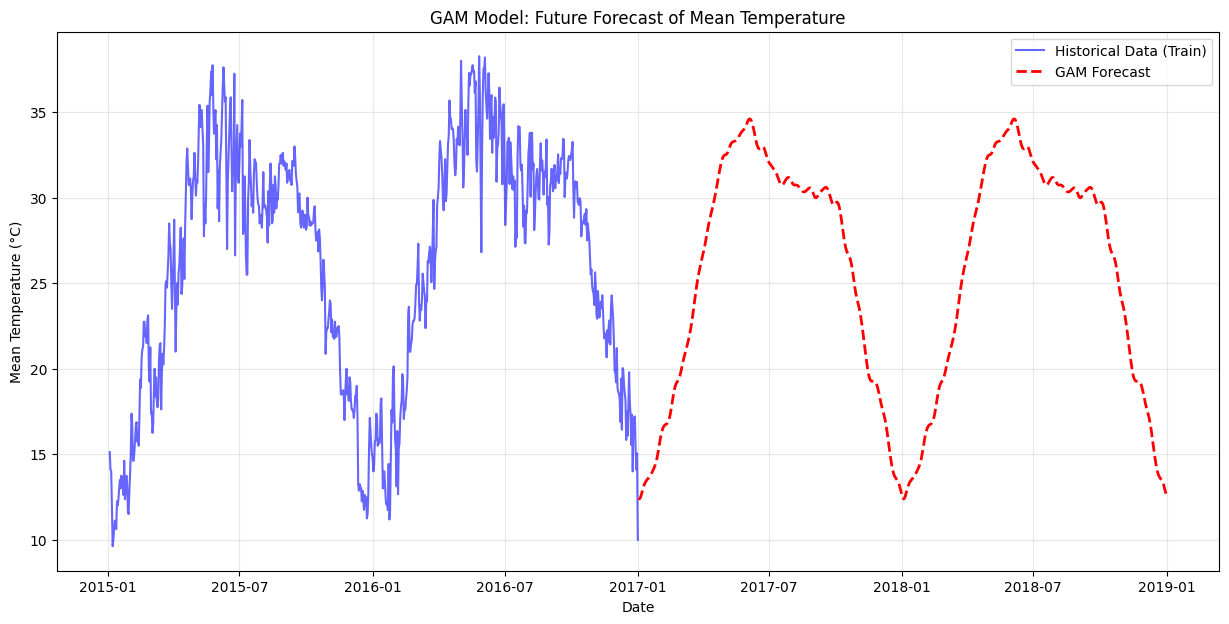

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create date index for future forecast
# Assuming train_ds2 'date' column is already datetime type
last_train_date = train_ds2['date'].iloc[-1]
future_dates = pd.date_range(start=last_train_date + pd.Timedelta(days=1), periods=n_dias_futuro_gam, freq='D')

plt.figure(figsize=(15, 7))

# Plot historical training data (e.g., last 2 years)
plt.plot(train_ds2['date'].iloc[-730:], train_ds2['meantemp'].iloc[-730:], label='Historical Data (Train)', color='blue', alpha=0.6)

# Plot forecasted values
plt.plot(future_dates, y_pred_futuro_gam, label='GAM Forecast', color='red', linestyle='--', linewidth=2)

plt.title('GAM Model: Future Forecast of Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

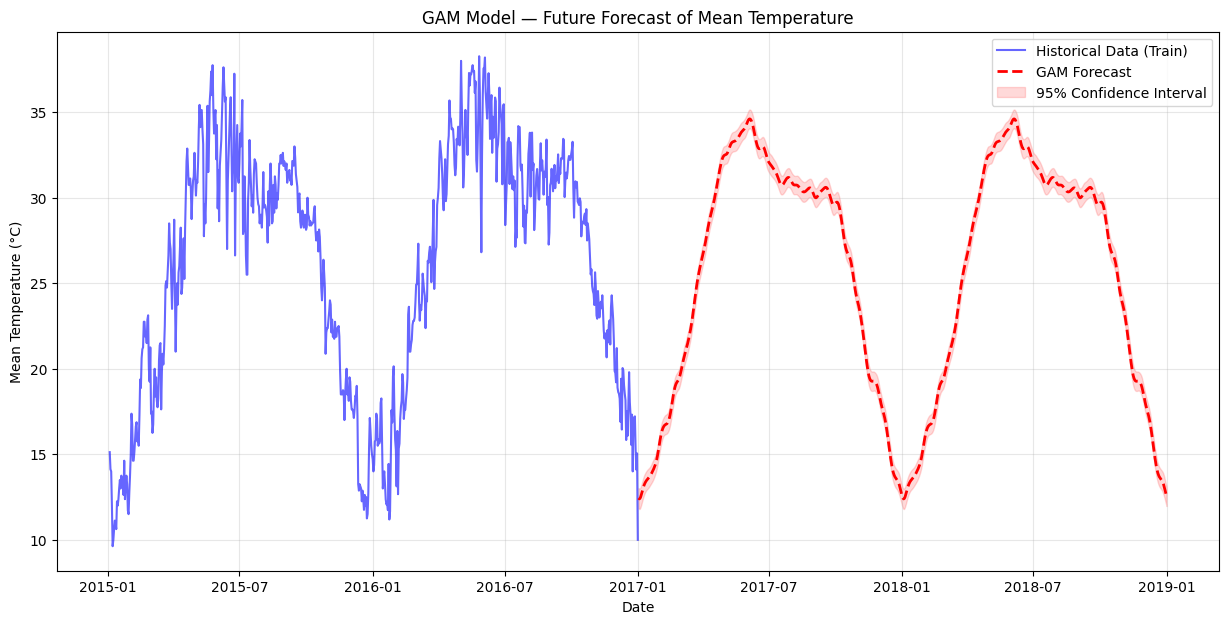

0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Construir datas futuras ---
last_train_date = train_ds2['date'].iloc[-1]
future_dates = pd.date_range(
    start=last_train_date + pd.Timedelta(days=1),
    periods=n_dias_futuro_gam,
    freq='D'
)

# --- Previsão ---
y_pred_futuro_gam = gam.predict(X_futuro_gam)

# --- Intervalo de confiança ---
ic_futuro = gam.confidence_intervals(X_futuro_gam, width=0.95)
lower_fut = ic_futuro[:, 0]
upper_fut = ic_futuro[:, 1]

# --- Plot ---
plt.figure(figsize=(15, 7))

# Histórico (últimos 2 anos)
plt.plot(
    train_ds2['date'].iloc[-730:],
    train_ds2['meantemp'].iloc[-730:],
    label='Historical Data (Train)',
    color='blue',
    alpha=0.6
)

# Previsão GAM
plt.plot(
    future_dates,
    y_pred_futuro_gam,
    label='GAM Forecast',
    color='red',
    linestyle='--',
    linewidth=2
)

# IC 95%
plt.fill_between(
    future_dates,
    lower_fut,
    upper_fut,
    color='red',
    alpha=0.15,
    label='95% Confidence Interval'
)

plt.title('GAM Model — Future Forecast of Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
0